In [6]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [42]:
from transformers import EncoderDecoderModel, RobertaTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch
import pandas as pd

In [4]:
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = EncoderDecoderModel.from_encoder_decoder_pretrained("microsoft/codebert-base", "microsoft/codebert-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['encoder.layer.0.crossattention.output.LayerNorm.bias', 'encoder.layer.0.crossattention.output.LayerNorm.weight', 'encoder.layer.0.crossattention.output.dense.bias', 'encoder.layer.0.crossattention.output.dense.weight', 'encoder.layer.0.crossattention.self.key.bias', 'encoder.layer.0.crossattention.self.key.weight', 'encoder.layer.0.crossattention.self.query.bias', 'encoder.layer.0.crossattention.self.query.weight', 'encoder.layer.0.crossattention.self.value.bias', 'encoder.layer.0.crossattention.self.value.weight', 'encoder.layer.1.crossattention.output.LayerNorm.bias', 'encoder.layer.1.crossattention.output.LayerNorm.weight', 'encoder.layer.1.crossattention.output.dense.bias', 'encoder.layer.1.crossattention.output.dense.weight', 'encoder.layer.1.crossattention.self.key.bias', 'encoder.layer.1.crossattention.self.key.weight', 'encoder.layer.1.crossa

In [11]:
model.config.decoder_start_token_id = tokenizer.bos_token_id  # Start token: <s>
model.config.pad_token_id = tokenizer.pad_token_id  # Padding token: <pad>
model.config.eos_token_id = tokenizer.eos_token_id  # End token: </s>


model.config.vocab_size = model.config.decoder.vocab_size

In [5]:
dtype = None
model = model.to(dtype).to('cuda')

### Dataset Preprocessing

In [7]:
from datasets import load_dataset
dataset = load_dataset("code_search_net", "python", trust_remote_code=True)

dataset

README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

code_search_net.py:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

python.zip:   0%|          | 0.00/941M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
        num_rows: 412178
    })
    test: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
        num_rows: 22176
    })
    validation: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
        num_rows: 23107
    })
})

In [8]:
import re

def mask_comments(batch):
    # The function now processes a batch of code strings to mask comments
    masked_code_strings = []
    for code_string in batch['func_code_string']:
        # Remove single-line comments
        code = re.sub(r"#.*", "", code_string)
        # Mask multi-line comments (both """ and ''')
        code = re.sub(r"'''(.*?)'''", "[MASK]", code, flags=re.DOTALL)
        code = re.sub(r'"""(.*?)"""', "[MASK]", code, flags=re.DOTALL)
        masked_code_strings.append(code.strip())

    # Update the batch with masked code strings
    batch['func_code_string'] = masked_code_strings
    return batch


def preprocess_function(examples):
    contextual_inputs = [
        f"{repo} {path} <sep> {code}"
        for repo, path, code in zip(
            examples['repository_name'],
            examples['func_path_in_repository'],
            examples['func_code_string']
        )
    ]

    inputs = tokenizer(contextual_inputs, truncation=True, padding="max_length", max_length=256)
    outputs = tokenizer(examples["func_documentation_string"], truncation=True, padding="max_length", max_length=256)

    inputs['labels'] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in label_list]
        for label_list in outputs['input_ids']
    ]

    return inputs

In [9]:
dataset_with_masks = dataset.map(mask_comments, batched=True)
tokenized_dataset = dataset_with_masks.map(preprocess_function, batched=True)

Map:   0%|          | 0/412178 [00:00<?, ? examples/s]

Map:   0%|          | 0/22176 [00:00<?, ? examples/s]

Map:   0%|          | 0/23107 [00:00<?, ? examples/s]

Map:   0%|          | 0/412178 [00:00<?, ? examples/s]

Map:   0%|          | 0/22176 [00:00<?, ? examples/s]

Map:   0%|          | 0/23107 [00:00<?, ? examples/s]

### Training

In [12]:
training_args = Seq2SeqTrainingArguments(
    output_dir='./cb_results',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps = 2,
    num_train_epochs=1,
    # max_steps=1000,
    weight_decay=0.03,
    warmup_steps=200,
    logging_dir='./cb_logs',
    logging_steps=500,
    eval_strategy="steps",
    eval_steps=500,
    save_steps=2000,
    save_total_limit=5,
    metric_for_best_model="eval_loss",
    load_best_model_at_end=True,
    greater_is_better=False,
    seed=3407,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer
)

trainer.train()

<ipython-input-12-73a04f53bda3>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior

Step,Training Loss,Validation Loss
500,5.893800,4.356024
1000,3.927200,3.844194
1500,3.509300,3.566925
2000,3.273200,3.361777
2500,3.106300,3.229608
3000,3.000800,3.112828
3500,2.886700,3.028748
4000,2.808400,2.954930
4500,2.727700,2.891155
5000,2.685400,2.832563


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.10/dist-packages/tra

TrainOutput(global_step=12881, training_loss=2.789051464297888, metrics={'train_runtime': 6776.6851, 'train_samples_per_second': 60.823, 'train_steps_per_second': 1.901, 'total_flos': 1.2643864151389286e+17, 'train_loss': 2.789051464297888, 'epoch': 1.0})

### Saving Model Checkpoints

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import os
import shutil

source_folder = '/content/cb_results'
destination_folder = '/content/drive/My Drive/DL_FinalProject/checkpoints'

os.makedirs(destination_folder, exist_ok=True)

In [15]:
# Copy files from source to destination
if os.path.exists(source_folder):
    shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
else:
    print(f"Source folder {source_folder} does not exist. Please check the source path.")

In [16]:
model.save_pretrained("best_model/codebert_python_1epoch")
tokenizer.save_pretrained("best_model/codebert_python_1epoch")

('best_model/codebert_python_1epoch/tokenizer_config.json',
 'best_model/codebert_python_1epoch/special_tokens_map.json',
 'best_model/codebert_python_1epoch/vocab.json',
 'best_model/codebert_python_1epoch/merges.txt',
 'best_model/codebert_python_1epoch/added_tokens.json')

In [17]:
source_folder = '/content/best_model/codebert_python_1epoch'
destination_folder = '/content/drive/My Drive/DL_FinalProject/checkpoints/best_model_python_1epoch'

os.makedirs(destination_folder, exist_ok=True)

In [18]:
import os
import shutil

if os.path.exists(source_folder):
    shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
else:
    print(f"Source folder {source_folder} does not exist. Please check the source path.")

### Single Datapoint Inference

In [19]:
test_dataset = tokenized_dataset['test']

input = test_dataset['func_code_string'][0]
print("Input: ", input)

expected_output = test_dataset['func_documentation_string'][0]
print("\nExpected Output: ", expected_output)

Input:  def get_vid_from_url(url):
        [MASK]
        return match1(url, r'youtu\.be/([^?/]+)') or \
          match1(url, r'youtube\.com/embed/([^/?]+)') or \
          match1(url, r'youtube\.com/v/([^/?]+)') or \
          match1(url, r'youtube\.com/watch/([^/?]+)') or \
          parse_query_param(url, 'v') or \
          parse_query_param(parse_query_param(url, 'u'), 'v')

Expected Output:  Extracts video ID from URL.


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)

Device being used: cuda


In [36]:
# Tokenize the input
inputs = tokenizer(input, return_tensors="pt", max_length=512, truncation=True)
input_ids = inputs.input_ids.to(device)
print("Input IDs device:", input_ids.device)

Input IDs device: cuda:0


In [37]:
model.to(device)
print("Model device:", next(model.parameters()).device)

Model device: cuda:0


In [40]:
print("Model device:", next(model.parameters()).device)
print("Input IDs device:", inputs.input_ids.device)
print("Attention Mask device:", inputs["attention_mask"].device)

Model device: cuda:0
Input IDs device: cpu
Attention Mask device: cpu


In [38]:
# Generate documentation
output_ids = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"]
)

# Decode the generated text
generated_doc = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Generated Documentation:", generated_doc)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [26]:
def get_code_predictions(code_snippets):
    inputs = tokenizer(code_snippets, padding=True, truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    with torch.no_grad():
        # outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        outputs = model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
        predictions = outputs.logits

    decoded_predictions = []
    for i in range(predictions.shape[0]):
        mask_token_index = (input_ids[i] == tokenizer.mask_token_id).nonzero(as_tuple=True)[0]
        for idx in mask_token_index:
            predicted_token_id = torch.argmax(predictions[i, idx]).item()
            predicted_token = tokenizer.decode([predicted_token_id])
            decoded_predictions.append(predicted_token)

    return decoded_predictions

predicted_tokens = get_code_predictions([input])
for snippet, token, exp_output in zip([input], predicted_tokens, [expected_output]):
    print(f"Code Snippet: {snippet}\nPredicted Comment: {token}\nActualComment: {exp_output}")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

### Entire Dataset Testing

In [41]:
def clear_cuda():
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.synchronize()

        torch.cuda.reset_peak_memory_stats()
        torch.cuda.reset_accumulated_memory_stats()

        with torch.cuda.device('cuda'):
            torch.cuda.empty_cache()

if torch.cuda.is_available():
    print("Clearing CUDA memory...")
    clear_cuda()
    print("CUDA memory cleared.")

Clearing CUDA memory...
CUDA memory cleared.


In [43]:
batch_size = 30
predicted_comments = []
actual_comments = []
comparison_results = []

for i in range(0, len(dataset['test']['func_code_string']), batch_size):
    print("Batch: ", i, " to ", i + batch_size)
    batch_code_snippets = dataset['test']['func_code_string'][i:i + batch_size]
    batch_actuals = dataset['test']['func_documentation_string'][i:i + batch_size]

    inputs = tokenizer(batch_code_snippets, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")

    with torch.no_grad():
        predictions = model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        # predictions = torch.argmax(outputs.logits, dim=-1)

    batch_predictions = [tokenizer.decode(predictions[j], skip_special_tokens=True) for j in range(predictions.size(0))]
    predicted_comments.extend(batch_predictions)

    actual_comments.extend(batch_actuals)

    batch_comparison = [pred.strip().lower() == actual.strip().lower() for pred, actual in zip(batch_predictions, batch_actuals)]
    comparison_results.extend(batch_comparison)

    del inputs
    # del outputs
    torch.cuda.empty_cache()
    clear_cuda()

results_df = pd.DataFrame({
    'Predicted Comment': predicted_comments,
    'Actual Comment': actual_comments,
    'Comparison Result': comparison_results
})

print(results_df.head())


Batch:  0  to  30


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Batch:  30  to  60
Batch:  60  to  90
Batch:  90  to  120
Batch:  120  to  150
Batch:  150  to  180
Batch:  180  to  210
Batch:  210  to  240
Batch:  240  to  270
Batch:  270  to  300
Batch:  300  to  330
Batch:  330  to  360
Batch:  360  to  390
Batch:  390  to  420
Batch:  420  to  450
Batch:  450  to  480
Batch:  480  to  510
Batch:  510  to  540
Batch:  540  to  570
Batch:  570  to  600
Batch:  600  to  630
Batch:  630  to  660
Batch:  660  to  690
Batch:  690  to  720
Batch:  720  to  750
Batch:  750  to  780
Batch:  780  to  810
Batch:  810  to  840
Batch:  840  to  870
Batch:  870  to  900
Batch:  900  to  930
Batch:  930  to  960
Batch:  960  to  990
Batch:  990  to  1020
Batch:  1020  to  1050
Batch:  1050  to  1080
Batch:  1080  to  1110
Batch:  1110  to  1140
Batch:  1140  to  1170
Batch:  1170  to  1200
Batch:  1200  to  1230
Batch:  1230  to  1260
Batch:  1260  to  1290
Batch:  1290  to  1320
Batch:  1320  to  1350
Batch:  1350  to  1380
Batch:  1380  to  1410
Batch:  1410

In [44]:
results_df.head()

,Predicted Comment,Actual Comment,Comparison Result
0,Return a string containing the video id.\n\n ...,Extracts video ID from URL.,False
1,Convert a string to a list of strings.\n\n ...,str->list\n Convert XML to URL List.\n F...,False
2,Return the MID for the given UID.,From http://cdn37.atwikiimg.com/sitescript/pub...,False
3,Download a video from the video.,wrapper,False
4,Download video from a video.\n\n :param url...,Downloads Dailymotion videos by URL.,False


In [45]:
clear_cuda()

### Performance Eval

#### 1. BLEU Score

In [46]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu_scores(df):
    bleu_scores = []

    for predicted, actual in zip(df['Predicted Comment'], df['Actual Comment']):
        # Tokenize the sentences
        reference = [actual.split()]
        candidate = predicted.split()

        # Calculate BLEU score for 1-gram
        score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))  # This sets up weights for only 1-gram
        bleu_scores.append(score)

    return bleu_scores

results_df['BLEU Score'] = calculate_bleu_scores(results_df)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [47]:
results_df.head()

,Predicted Comment,Actual Comment,Comparison Result,BLEU Score
0,Return a string containing the video id.\n\n ...,Extracts video ID from URL.,False,0.125
1,Convert a string to a list of strings.\n\n ...,str->list\n Convert XML to URL List.\n F...,False,0.200
2,Return the MID for the given UID.,From http://cdn37.atwikiimg.com/sitescript/pub...,False,0.000
3,Download a video from the video.,wrapper,False,0.000
4,Download video from a video.\n\n :param url...,Downloads Dailymotion videos by URL.,False,0.000


#### 2. ROUGE Score

In [48]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=a5b6c00276bb08149762f70ba912cf5d92c158d5c513c004411c52d1df1565c3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [49]:
from rouge_score import rouge_scorer

def calculate_rouge_scores(df):
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

    rouge_scores = []

    for predicted, actual in zip(df['Predicted Comment'], df['Actual Comment']):
        scores = scorer.score(actual, predicted)
        rouge_scores.append(scores['rouge1'].fmeasure)  # Focusing on F-measure for ROUGE-1

    return rouge_scores

results_df['ROUGE-1 F Score'] = calculate_rouge_scores(results_df)

In [54]:
results_df.head(10)

,Predicted Comment,Actual Comment,Comparison Result,BLEU Score,ROUGE-1 F Score
0,Return a string containing the video id.\n\n ...,Extracts video ID from URL.,False,0.125000,0.307692
1,Convert a string to a list of strings.\n\n ...,str->list\n Convert XML to URL List.\n F...,False,0.200000,0.421053
2,Return the MID for the given UID.,From http://cdn37.atwikiimg.com/sitescript/pub...,False,0.000000,0.000000
3,Download a video from the video.,wrapper,False,0.000000,0.000000
4,Download video from a video.\n\n :param url...,Downloads Dailymotion videos by URL.,False,0.000000,0.375000
5,Return a dictionary of the attributes of the g...,http://stackoverflow.com/a/30923963/2946714,False,0.000000,0.111111
6,Downloads a video from a video.\n\n :param ...,video page,False,0.100000,0.166667
7,Download a course.,course page,False,0.000000,0.400000
8,Download a video from a video.\n\n :param v...,Downloads a Sina video by its unique vid.\n ...,False,0.222222,0.363636
9,Downloads video from a video file.\n\n Args...,Downloads a Sina video by its unique vkey.\n ...,False,0.322062,0.421053


In [51]:
clear_cuda()

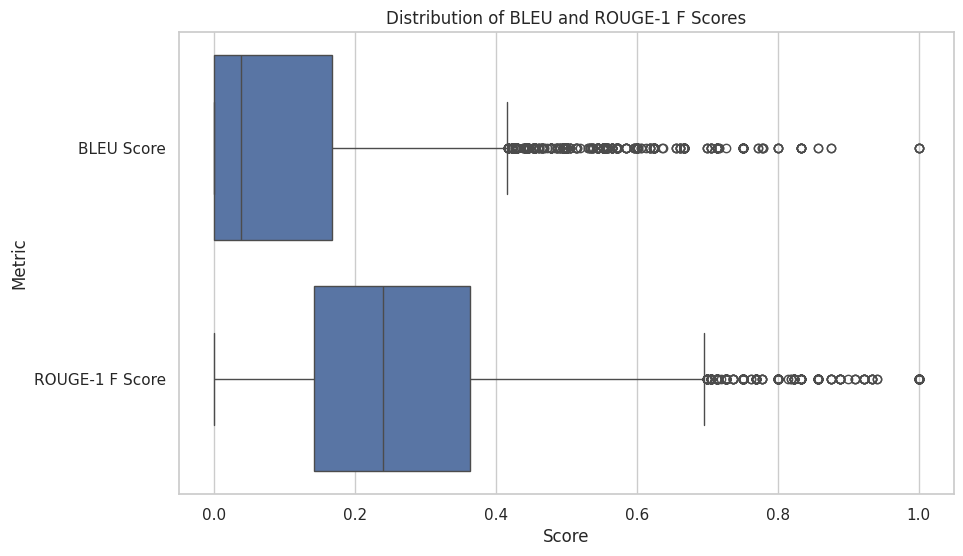

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

long_df = results_df.melt(value_vars=['BLEU Score', 'ROUGE-1 F Score'],
                          var_name='Metric', value_name='Score')

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(x='Score', y='Metric', data=long_df, orient='h')

plt.title('Distribution of BLEU and ROUGE-1 F Scores')
plt.xlabel('Score')
plt.ylabel('Metric')

# Display the plot
plt.show()

In [53]:
bleu_mean = results_df['BLEU Score'].mean()
bleu_min = results_df['BLEU Score'].min()
bleu_max = results_df['BLEU Score'].max()

rouge_mean = results_df['ROUGE-1 F Score'].mean()
rouge_min = results_df['ROUGE-1 F Score'].min()
rouge_max = results_df['ROUGE-1 F Score'].max()

print(f"BLEU Score - Mean: {bleu_mean:.4f}, Min: {bleu_min:.4f}, Max: {bleu_max:.4f}")
print(f"ROUGE-1 F Score - Mean: {rouge_mean:.4f}, Min: {rouge_min:.4f}, Max: {rouge_max:.4f}")

BLEU Score - Mean: 0.1038, Min: 0.0000, Max: 1.0000
ROUGE-1 F Score - Mean: 0.2671, Min: 0.0000, Max: 1.0000
